<a href="https://colab.research.google.com/github/jarek-pawlowski/machine-learning-applications/blob/main/regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reguralization in CNN networks
- we are going to compare various approaches to regularizarion in neural networks,
- we will use standard image classification task with CNN networks.

In [68]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

import numpy as np

import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

model_args = {}
# we will use batch size of 64 in Stochastic Gradient Descent (SGD) optimization of the network
model_args['batch_size'] = 64 
# learning rate is how fast it will descend
model_args['lr'] = .07
# the number of epochs is the number of times you go through the full dataset
model_args['epochs'] = 20
# L2 (ridge) penalty
model_args['L2_lambda'] = 5.e-3
# L1 (LASSO) penalty
model_args['L1_lambda'] = 2.e-4

### Define problem
- we are going to use CIFAR-10 [dataset](https://www.cs.toronto.edu/~kriz/cifar.html) of 32x32 color images to train image classifier,
- in order to test various regularizations our vanilla CNN classifier should be overfitted.

### Download the dataset

In [30]:
!rm -r ./data
# normalize dataset
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize(mean, std)])

cifar10_train = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# we divide this data into training and validation subsets
train_subset, validation_subset = torch.utils.data.random_split(cifar10_train, [40000, 10000])
test_subset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# subsample to speedup training (colab has notebook lifetime limit)
train_subset = torch.utils.data.Subset(train_subset, range(20000))
validation_subset = torch.utils.data.Subset(validation_subset, range(5000))
test_subset = torch.utils.data.Subset(test_subset, range(5000))

# define dataloaders
loader_kwargs = {'batch_size': model_args['batch_size'], 
                 'num_workers': 2, 
                 'pin_memory': True, 
                 'shuffle': True}
train_loader = torch.utils.data.DataLoader(train_subset, **loader_kwargs)
validation_loader = torch.utils.data.DataLoader(validation_subset, **loader_kwargs)
test_loader = torch.utils.data.DataLoader(test_subset, **loader_kwargs)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck')

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### Define CNN models and util methods
- (over)simpified CNN
- VGG11 (definition borrowed from *https://github.com/chengyangfu/pytorch-vgg-cifar10*)


In [31]:
class SimpleCNN(nn.Module):
    '''
    simple CNN model
    '''
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 80)
        self.fc3 = nn.Linear(80, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class VGG(nn.Module):
    '''
    VGG model 
    '''
    def __init__(self, features):
        super(VGG, self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512, 512),
            nn.ReLU(True),
            nn.Linear(512, 10),
        )
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg, batch_norm=False):
    layers = []
    in_channels = 3
    for v in cfg:
        if v == 'M':
            layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
        else:
            conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
            if batch_norm:
                layers += [conv2d, nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
            else:
                layers += [conv2d, nn.ReLU(inplace=True)]
            in_channels = v
    return nn.Sequential(*layers)

vgg_cfg = {
    'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
    'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
    'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
    'vgg22': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 256, 'M', 512, 512, 512, 512, 512, 'M', 512, 512, 512, 512, 512, 'M']
}


def train_with_regularization(model, device, train_loader, optimizer, criterion, 
                              epoch_number, 
                              L1_lambda, 
                              L2_lambda):
    model.train()
    train_loss = 0.
    # get subsequent batches over the data in a given epoch
    for batch_idx, (data, target) in enumerate(train_loader):
        # send data tensors to GPU (or CPU)
        data, target = data.to(device), target.to(device)
        # this will zero out the gradients for this batch
        optimizer.zero_grad()
        # this will execute the forward() function
        output = model(data)
        # calculate loss using c
        loss = criterion(output, target)
        # L2 regularization implemeted by hand
        L2_norm = sum((p**2).sum() for p in model.parameters())
        # L1 regularization
        L1_norm = sum(p.abs().sum() for p in model.parameters())
        #
        loss_regularized = loss + L1_norm*L1_lambda + L2_norm*L2_lambda
        # backpropagate the loss
        loss_regularized.backward()
        # update the model weights (with assumed learning rate)
        optimizer.step()
        train_loss += loss.item()
    print('Train Epoch: {}'.format(epoch_number))
    train_loss /= len(train_loader)
    print('\tTrain set: Average loss: {:.4f}'.format(train_loss))
    return train_loss
    
def test(model, device, test_loader, criterion, message=None):
    model.eval()
    test_loss = 0.
    correct = 0
    # this is just inference, we don't need to calculate gradients
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device) 
            output = model(data)
            # calculate and sum up batch loss
            test_loss += criterion(output, target) 
            # get the index of class with the max probability 
            prediction = output.argmax(dim=1)  
            #_, predicted = torch.max(outputs.data, axis=1)
            # item() returns value of the given tensor
            correct += prediction.eq(target).sum().item()
    test_loss /= len(test_loader)
    accuracy = correct / len(test_loader.dataset)
    if message is not None:
        print('\t{}: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
            message, test_loss, correct, len(test_loader.dataset), 100.*accuracy))
    return test_loss.cpu(), accuracy

def run_training(model, device, criterion, optimizer, no_epochs,
                 L1_lambda=0., 
                 L2_lambda=0.):
    train_loss = []
    validation_loss = []
    validation_accuracy = []
    test_accuracy = []
    for epoch_number in range(1, no_epochs+1):
        train_loss.append(train_with_regularization(model, device, train_loader, 
                                optimizer, criterion, epoch_number,
                                L1_lambda, L2_lambda))
        val_loss, val_acc = test(model, device, validation_loader, 
                                criterion, 'Validation set')
        validation_loss.append(val_loss)
        validation_accuracy.append(val_acc)
        # we also collect test accuracies for every epoch
        _, test_acc = test(model, device, test_loader, criterion)
        test_accuracy.append(test_acc)
    # and select test accuracy for the best epoch (with the highest validation accuracy)
    best_accuracy = test_accuracy[np.argmax(validation_accuracy)]
    return train_loss, validation_loss, best_accuracy

def plot_loss(train_loss, validation_loss, title):
    plt.grid(True)
    plt.xlabel("subsequent epochs")
    plt.ylabel('average loss')
    plt.plot(range(1, len(train_loss)+1), train_loss, 'o-', label='training')
    plt.plot(range(1, len(validation_loss)+1), validation_loss, 'o-', label='validation')
    plt.legend()
    plt.title(title)
    plt.show()

### Do the experiments
- without any regularization
- *weigt_decay*, L2 regularization implemeted in optimizer, e.g. Adam or SGD as here: see [discussion](https://discuss.pytorch.org/t/how-does-sgd-weight-decay-work/33105/6)
- L2 and L1 regularization implemeted by hand

Train Epoch: 1
	Train set: Average loss: 2.0937
	Validation set: Average loss: 1.8362, Accuracy: 1617/5000 (32%)
Train Epoch: 2
	Train set: Average loss: 1.7053
	Validation set: Average loss: 1.6802, Accuracy: 1915/5000 (38%)
Train Epoch: 3
	Train set: Average loss: 1.5377
	Validation set: Average loss: 1.6614, Accuracy: 2028/5000 (41%)
Train Epoch: 4
	Train set: Average loss: 1.4247
	Validation set: Average loss: 1.4561, Accuracy: 2363/5000 (47%)
Train Epoch: 5
	Train set: Average loss: 1.3424
	Validation set: Average loss: 1.4616, Accuracy: 2409/5000 (48%)
Train Epoch: 6
	Train set: Average loss: 1.2649
	Validation set: Average loss: 1.4852, Accuracy: 2460/5000 (49%)
Train Epoch: 7
	Train set: Average loss: 1.2045
	Validation set: Average loss: 1.3214, Accuracy: 2617/5000 (52%)
Train Epoch: 8
	Train set: Average loss: 1.1367
	Validation set: Average loss: 1.3273, Accuracy: 2668/5000 (53%)
Train Epoch: 9
	Train set: Average loss: 1.0846
	Validation set: Average loss: 1.4069, Accuracy:

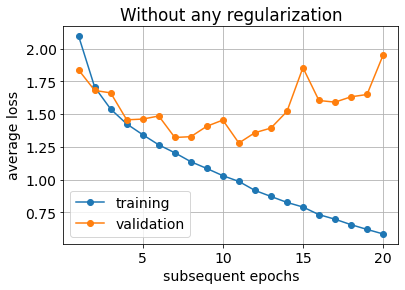

In [37]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'],
                      weight_decay=0.)

train_loss_0, val_loss_0, best_accuracy = run_training(model, device, criterion, optimizer, model_args['epochs'])

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_0, val_loss_0, 'Without any regularization')
model_0_params = [p.detach().cpu().numpy() for p in model.parameters()]

Train Epoch: 1
	Train set: Average loss: 2.0456
	Validation set: Average loss: 1.8785, Accuracy: 1510/5000 (30%)
Train Epoch: 2
	Train set: Average loss: 1.6909
	Validation set: Average loss: 1.6338, Accuracy: 1925/5000 (38%)
Train Epoch: 3
	Train set: Average loss: 1.5336
	Validation set: Average loss: 1.6605, Accuracy: 2065/5000 (41%)
Train Epoch: 4
	Train set: Average loss: 1.4370
	Validation set: Average loss: 1.4694, Accuracy: 2375/5000 (48%)
Train Epoch: 5
	Train set: Average loss: 1.3759
	Validation set: Average loss: 1.4056, Accuracy: 2553/5000 (51%)
Train Epoch: 6
	Train set: Average loss: 1.3181
	Validation set: Average loss: 1.4678, Accuracy: 2335/5000 (47%)
Train Epoch: 7
	Train set: Average loss: 1.2665
	Validation set: Average loss: 1.3184, Accuracy: 2658/5000 (53%)
Train Epoch: 8
	Train set: Average loss: 1.2143
	Validation set: Average loss: 1.3742, Accuracy: 2641/5000 (53%)
Train Epoch: 9
	Train set: Average loss: 1.1958
	Validation set: Average loss: 1.3945, Accuracy:

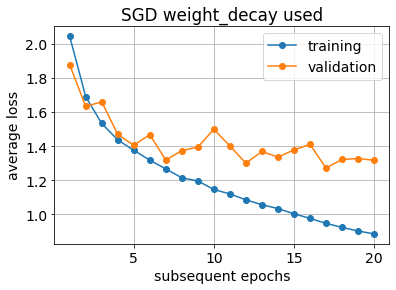

In [56]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'],
                      weight_decay=model_args['L2_lambda'])

train_loss_wd, val_loss_wd, best_accuracy = run_training(model, device, criterion, optimizer, model_args['epochs'])

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_wd, val_loss_wd, 'SGD weight_decay used')
model_wd_params = [p.detach().cpu().numpy() for p in model.parameters()]

Train Epoch: 1
	Train set: Average loss: 2.0349
	Validation set: Average loss: 1.9111, Accuracy: 1601/5000 (32%)
Train Epoch: 2
	Train set: Average loss: 1.7201
	Validation set: Average loss: 1.9958, Accuracy: 1665/5000 (33%)
Train Epoch: 3
	Train set: Average loss: 1.5596
	Validation set: Average loss: 1.5181, Accuracy: 2290/5000 (46%)
Train Epoch: 4
	Train set: Average loss: 1.4679
	Validation set: Average loss: 1.5002, Accuracy: 2326/5000 (47%)
Train Epoch: 5
	Train set: Average loss: 1.3908
	Validation set: Average loss: 1.4500, Accuracy: 2485/5000 (50%)
Train Epoch: 6
	Train set: Average loss: 1.3188
	Validation set: Average loss: 1.3947, Accuracy: 2522/5000 (50%)
Train Epoch: 7
	Train set: Average loss: 1.2678
	Validation set: Average loss: 1.4287, Accuracy: 2434/5000 (49%)
Train Epoch: 8
	Train set: Average loss: 1.2149
	Validation set: Average loss: 1.5703, Accuracy: 2427/5000 (49%)
Train Epoch: 9
	Train set: Average loss: 1.1769
	Validation set: Average loss: 1.2355, Accuracy:

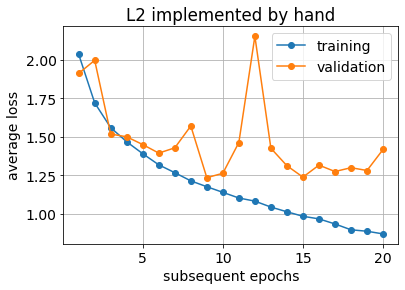

In [59]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'],
                      weight_decay=0.)

train_loss_l2, val_loss_l2, best_accuracy = run_training(model, device, criterion, optimizer, model_args['epochs'],
                                                         L1_lambda=0.,
                                                         L2_lambda=model_args['L2_lambda']/2.)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_l2, val_loss_l2, 'L2 implemented by hand')
model_l2_params = [p.detach().cpu().numpy() for p in model.parameters()]

Train Epoch: 1
	Train set: Average loss: 2.0473
	Validation set: Average loss: 1.7564, Accuracy: 1766/5000 (35%)
Train Epoch: 2
	Train set: Average loss: 1.6842
	Validation set: Average loss: 2.0975, Accuracy: 1466/5000 (29%)
Train Epoch: 3
	Train set: Average loss: 1.5528
	Validation set: Average loss: 1.4636, Accuracy: 2396/5000 (48%)
Train Epoch: 4
	Train set: Average loss: 1.4554
	Validation set: Average loss: 1.5266, Accuracy: 2266/5000 (45%)
Train Epoch: 5
	Train set: Average loss: 1.3898
	Validation set: Average loss: 1.4993, Accuracy: 2396/5000 (48%)
Train Epoch: 6
	Train set: Average loss: 1.3245
	Validation set: Average loss: 1.4068, Accuracy: 2464/5000 (49%)
Train Epoch: 7
	Train set: Average loss: 1.2687
	Validation set: Average loss: 1.4788, Accuracy: 2446/5000 (49%)
Train Epoch: 8
	Train set: Average loss: 1.2179
	Validation set: Average loss: 1.4162, Accuracy: 2539/5000 (51%)
Train Epoch: 9
	Train set: Average loss: 1.1760
	Validation set: Average loss: 1.4658, Accuracy:

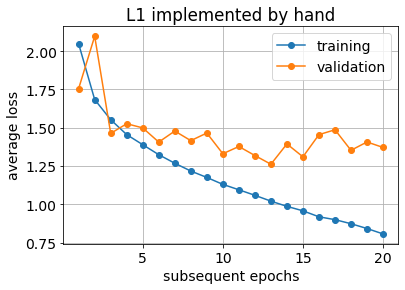

In [69]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), 
                      lr=model_args['lr'],
                      weight_decay=0.)

train_loss_l1, val_loss_l1, best_accuracy = run_training(model, device, criterion, optimizer, model_args['epochs'],
                                                         L1_lambda=model_args['L1_lambda'],
                                                         L2_lambda=0.)

print('\nTest accuracy for best epoch: {:.0f}%\n'.format(100.*best_accuracy))
plot_loss(train_loss_l1, val_loss_l1, 'L1 implemented by hand')
model_l1_params = [p.detach().cpu().numpy() for p in model.parameters()]

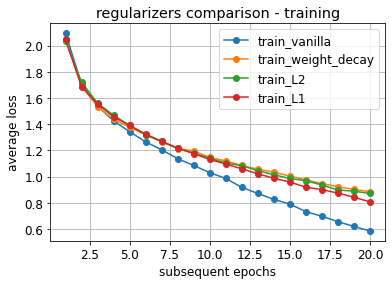

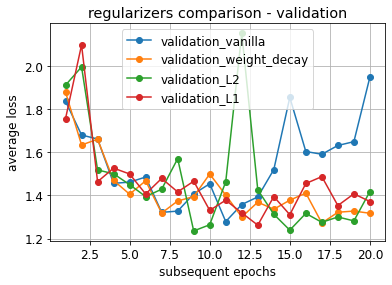

In [70]:
plt.rcParams.update({'font.size': 12})

plt.grid(True)
plt.xlabel("subsequent epochs")
plt.ylabel('average loss')
range_epochs = model_args['epochs']+1
plt.plot(range(1, range_epochs), train_loss_0,  'o-', label='train_vanilla')
plt.plot(range(1, range_epochs), train_loss_wd, 'o-', label='train_weight_decay')
plt.plot(range(1, range_epochs), train_loss_l2, 'o-', label='train_L2')
plt.plot(range(1, range_epochs), train_loss_l1, 'o-', label='train_L1')
plt.legend()
plt.title("regularizers comparison - training")
plt.show()

plt.grid(True)
plt.xlabel("subsequent epochs")
plt.ylabel('average loss')
range_epochs = model_args['epochs']+1
plt.plot(range(1, range_epochs), val_loss_0,  'o-', label='validation_vanilla')
plt.plot(range(1, range_epochs), val_loss_wd, 'o-', label='validation_weight_decay')
plt.plot(range(1, range_epochs), val_loss_l2, 'o-', label='validation_L2')
plt.plot(range(1, range_epochs), val_loss_l1, 'o-', label='validation_L1')
plt.legend()
plt.title("regularizers comparison - validation")
plt.show()

Example weights:

In [92]:
for p in model_0_params:
    print(p.shape)

np.set_printoptions(formatter={'float_kind': "{:.3f}".format})
# parameters for the second from last layer
print("vanilla:\n", model_0_params[-2][0])
print("L2 regularized:\n", model_l2_params[-2][0])
print("L1 regularized:\n", model_l1_params[-2][0])

(6, 3, 5, 5)
(6,)
(16, 6, 5, 5)
(16,)
(120, 400)
(120,)
(80, 120)
(80,)
(10, 80)
(10,)
vanilla:
 [0.283 0.005 -0.117 -0.248 0.044 0.295 -0.048 -0.100 0.252 0.109 -0.008
 0.149 0.026 0.128 0.004 0.098 -0.101 0.025 0.006 0.230 0.145 0.128 0.123
 -0.204 -0.316 -0.208 -0.111 -0.234 0.152 -0.308 -0.002 0.358 -0.109 0.164
 0.044 0.214 0.051 -0.282 0.046 -0.195 -0.191 0.280 0.192 0.194 0.105
 -0.312 0.030 0.151 -0.010 0.123 0.195 -0.281 -0.251 0.121 -0.044 0.197
 0.085 -0.031 0.204 -0.192 -0.135 -0.224 0.218 -0.283 -0.432 -0.262 0.173
 -0.146 0.199 -0.310 -0.020 0.166 0.030 0.012 0.121 0.361 0.048 0.327
 -0.152 0.181]
L2 regularized:
 [0.020 0.124 0.055 -0.155 -0.034 0.275 0.161 -0.170 0.038 -0.009 0.174
 0.036 0.148 -0.091 0.211 -0.247 -0.002 -0.082 -0.214 0.087 0.012 -0.155
 0.202 0.147 -0.172 0.080 0.038 0.083 0.005 0.214 0.012 -0.073 0.072 0.018
 -0.025 0.116 0.002 -0.005 -0.111 -0.027 0.169 -0.161 -0.148 0.164 -0.034
 0.077 -0.114 0.032 -0.227 0.364 0.013 -0.098 0.273 0.184 0.035 -0.089


### Tasks to do:

0. Try to play with L2 and L1 *lambdas* do get highest possible accuracy.
- e.g. what if we increase *L1_lambda* to be the same as *L2_lambda*
1. Repeat the calculations but for the VGG11 model.
2. Compare amplitudes (plot histograms?) of model weights for the L2 and L1 case -- is L1 a strong feature selector?

3. Reimplement pytorch [SGD method](https://github.com/pytorch/pytorch/blob/master/torch/optim/sgd.py) to get L1 regularization (|w| instead of w**2)

Hint: change line
```python
if weight_decay != 0:
    d_p = d_p.add(param, alpha=weight_decay)
```
to
```python
if weight_decay != 0:
    d_p = d_p.add(torch.sign(param), alpha=weight_decay) 
```